# Approaching Time Series Forecasting Problems 🗓

The goal of this lesson is to help students think through how to approach a time series problem.

## Learning Objectives
By the end of the lesson students should be familiar with:

- Holt-Winters Triple Exponential Smoothing
- SARIMAX
- auto-ARIMA

## Before modeling
- Get the time period into *datetime* dtype format and get it in the index
- Become comfortable with resampling and other pandas time series methods

## Modeling considerations
- Make sure you aren't leaking information from the future into your training data
- Make a null model (just the most recent prediction continued) first, so you have a baseline
- There are a lot of model possibilities of various complexity levels (e.g. weighted average, simple exponential smoothing, ARIMA)
- Consider the tradeoffs between complexity and performance when choosing which model to use

## Models that can handle more complexity well
- Holt-Winters (exponential smoothing)
- Prophet 
- SARIMAX 
- VAR
- Deep Neural Networks

## Holt-Winters (exponential smoothing)
[Holt Winters](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) often performs about as well as SARIMA. It requires much less tuning. It's part of the exponential smoothing family of algorithms. 

- It's also called *Triple Exponential Smoothing*

- You don't have to worry about stationarity. 

- It's available in statsmodels [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothing.html#statsmodels.tsa.statespace.exponential_smoothing.ExponentialSmoothing). 

Simple exponential smoothing uses weighted averages where the weights decrease exponentially for older data points.

Holt-Winters is more powerful because it accounts for seasonality and trend. 

The model is made up of trend, level, and seasonal components.

If the outcome variable is sales:

* The trend equation captures the overall direction of sales. 
* The level equation is a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time `t`. 
* The seasonal equation is a weighted average between the current seasonal index and the seasonal index of the same season `s` time periods ago. 

You have to choose the number of seasonal periods, and whether there are additive,  multiplicative, or damping.

You can also pass exogenous variables.

Here's what it looks like in code.

In [34]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels

In [35]:
statsmodels.__version__

'0.11.0'

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_winters = ExponentialSmoothing(
    (train['Weekly_Sales'].to_numpy()),  # note have to feed it numpy ndarray
    trend='mul', 
    seasonal='mul',
    seasonal_periods=52,

).fit()

df_predictions['Holt_Winters'] = holt_winters.forecast(len(test))


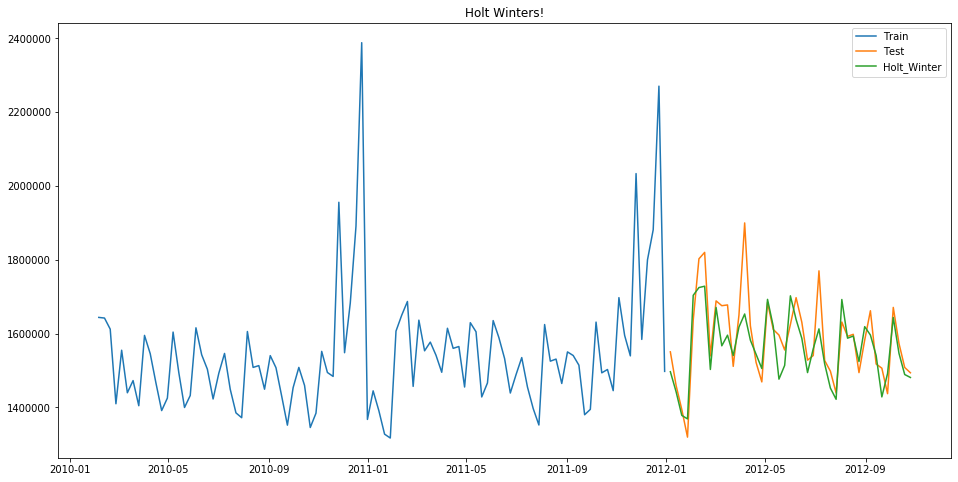

In [45]:
plt.figure(figsize=(16,8))
plt.plot( train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(df_predictions['Holt_Winters'], label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt Winters!")
plt.show()

What do you think of that curve?

Let's look at the RMSE to check accuracy.

In [32]:
rms = mean_squared_error(
    test['Weekly_Sales'], 
    df_predictions['Holt_Winters'], 
    squared=False
)
print(f'{rms:,.0f}')

66,350


## Prophet
Facebook created and opensourced the [Prophet](https://facebook.github.io/prophet/) library. 

[Here's](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a) a good article on what Prophet is doing.
"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects." 

An additive model is a nonparametric regression method.

Prophet requires much less tuning than SARIMA. Facebook finds it very helpful for advertising type data and it's convenient for adding things like holidays. It's relatively new and it's popular. 

## SARIMAX
You know ARIMA. 

SARIMA adds seasonality (and you get to choose 4 other parameters) 😀. 

There are 7 parameters to choose `(p, d, q)` `(P, D, Q)` and `m`. `p` is for the autoregressive component, `i` stands for *integrative* and is all about differencing, `q` is for the moving average component. The next three capitalized arguments are the same but for the Seasonality component. And `m` is for the number of observations per seasonal cylce. With weekly sales data with a holiday sesonality, that's would be 52 weeks, generally.

SARIMAX extends SARIMA. The X in [SARIMAX](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) stands for eXogenous variables. It allows you to add predictors that aren't just the prevoious outcome variable. For example, you can dummy encode a column to be a holiday/no holiday, (1/0).

## VAR

VAR is useful when you have multiple time series you want to include in your forecast.

VAR was touched on briefly in global and Mahdi has a whole repo [here](https://git.generalassemb.ly/DSI-US-11/local_var).

## Neural Networks
Deep neural networks can be used with time series data. There are a number of of architectures that can make sense. [Here's](https://towardsdatascience.com/deep-learning-for-time-series-and-why-deep-learning-a6120b147d60) a post on the topic if you are interested. If the relationship between the input variables and the outcome is not complex, this is probably overkill.

## Putting it all together

If you find a model that works really well, great!

If you are trying to get every last bit of performance, you can also ensemble your models. I have not done this.

## Next steps
I recommend checking out the great free ebook [Forecasting: Principles and Practice
Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/) to learn more about time series. 

Jason Brownlee aslo has a lot of great information and Python code on time series forecasting at [Machine Learning Mastery](https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/).

# Example: Store sales data

#### Read in the dataset, set the index and take a look at it.

In [6]:
df_walmart = pd.read_csv('data/train.csv', index_col='Date')

Alternatively, we could have set the index after creating the DataFrame.

In [7]:
# df_walmart = df_walmart.set_index('Date') 
df_walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [8]:
df_walmart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3+ MB


Let's make sure that index is a `datetime`.

In [9]:
df_walmart.index = pd.to_datetime(df_walmart.index)
df_walmart.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


#### Filter the DataFrame to Store 1 sales and aggregate over departments to compute the total sales per store.

In [10]:
store1 = df_walmart[df_walmart['Store'] == 1]

In [11]:
store1

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-08-31,1,99,20.06,False
2012-09-07,1,99,0.05,True
2012-09-14,1,99,0.03,False


In [12]:
store1_sales = store1['Weekly_Sales'].groupby(store1.index).sum()

In [13]:
store1_sales.head()

Date
2010-02-05    1643690.90
2010-02-12    1641957.44
2010-02-19    1611968.17
2010-02-26    1409727.59
2010-03-05    1554806.68
Name: Weekly_Sales, dtype: float64

In [14]:
type(store1_sales)

pandas.core.series.Series

Let's make that a DataFrame.

In [15]:
df_store1_sales = pd.DataFrame(store1_sales)

In [16]:
df_store1_sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [17]:
df_store1_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


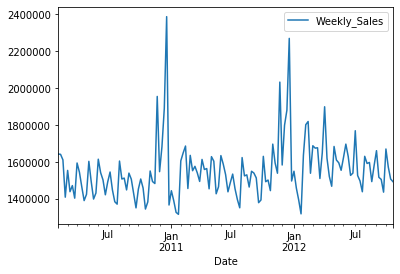

In [18]:
df_store1_sales.plot();

### Split the dataset into train and test sets.

We will subset the data to look at the accuracy of each time series forecasting method on the data set. We'll use the first two years (2010–2011) as the "training" data and the last year (2012) as the "testing" data for the purposes of our demonstration. 

Let's make two DataFrames.

In [19]:
train = df_store1_sales['2010': '2011']
test = df_store1_sales['2012']

In [20]:
train.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [21]:
test.head()

,Weekly_Sales
Date,
2012-01-06,1550369.92
2012-01-13,1459601.17
2012-01-20,1394393.84
2012-01-27,1319325.59
2012-02-03,1636339.65


Let's plot the two DataFrames

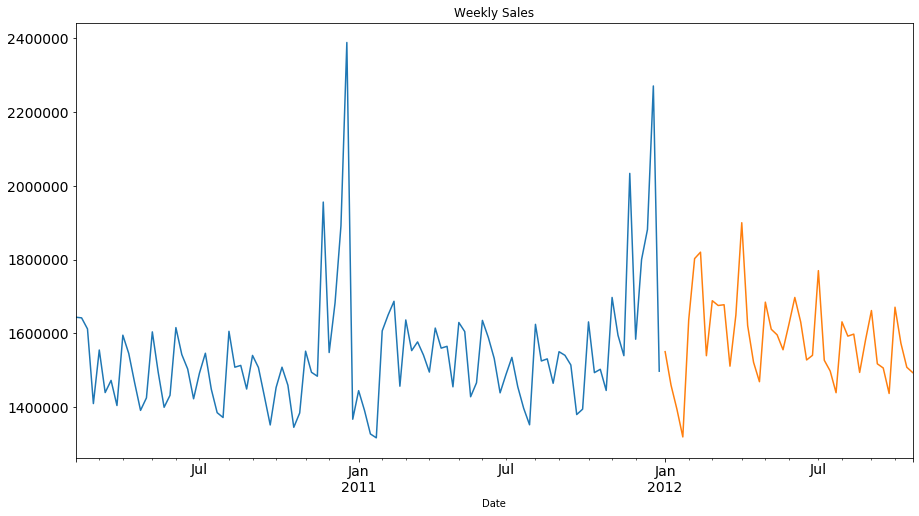

In [22]:
train['Weekly_Sales'].plot(figsize=(15,8))
test['Weekly_Sales'].plot(figsize=(15,8), title= 'Weekly Sales', fontsize=14)
plt.show()

## Method 1: Naive Forecast

Take the last time period's sales and estimate the same value for all future time periods. This method is called a **naive forecast**.

$${\Large \hat y_{t+1} = y_t}$$

#### Let's see how well the naive method does when forecasting sales.

Make a predictions DataFrame and set the predicted values equal to the last value in the `Weekly_Sales` df.

In [23]:
train.tail(2)

,Weekly_Sales
Date,
2011-12-23,2270188.99
2011-12-30,1497462.72


In [24]:
df_predictions = test.copy()  
df_predictions['naive'] = train['Weekly_Sales'].iloc[-1]
df_predictions

,Weekly_Sales,naive
Date,,
2012-01-06,1550369.92,1497462.72
2012-01-13,1459601.17,1497462.72
2012-01-20,1394393.84,1497462.72
2012-01-27,1319325.59,1497462.72
2012-02-03,1636339.65,1497462.72
2012-02-10,1802477.43,1497462.72
2012-02-17,1819870.00,1497462.72
2012-02-24,1539387.83,1497462.72
2012-03-02,1688420.76,1497462.72


Plot the historic data, the actual "future" data, and the predicted "future" data.

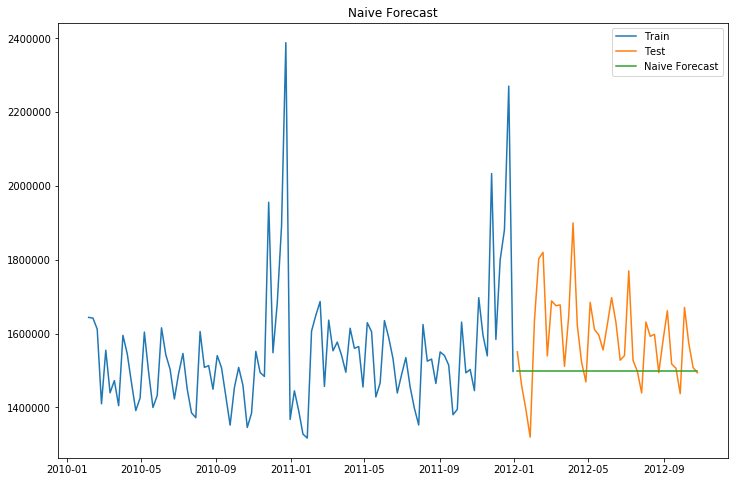

In [25]:
plt.figure(figsize=(12,8))

plt.plot(train.index, train['Weekly_Sales'], label='Train')
plt.plot(test.index, test['Weekly_Sales'], label='Test')
plt.plot(df_predictions.index, df_predictions['naive'], label='Naive Forecast')

plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

Let's check the model's performance on the test data set using the Root Mean Squared Error (RMSE) scoring metric. 

This `mean_squared_error metric` function can be imported from Scikit-learn (sklearn). 

In [26]:
from sklearn.metrics import mean_squared_error

### Set the squared argument to `False` to get the RMSE (or take the square root with `np.sqrt`) if you are using an older version of scikit-learn.

In [27]:
rms = mean_squared_error(
    test['Weekly_Sales'], 
    df_predictions['naive'], 
    squared=False)
print(f'{rms:,.0f}')

144,192


That's our baseline. 

We can infer from the RMSE value and the graph above that the naive method isn’t amazing for data sets with high variability. It's best suited for stable data sets. Let's try to improve the score with more sophisticated models. 

Note that we're looking at a prediction through the end of the time period as of a single date, we aren't assuming we're updating the model every week with new information. 

## SARIMA with Auto-arima package: pmdarima

There are a bunch of ways to find parameter values for SARIMA. You can use autocorrelation plots and partial correlation plots to try to figure out parameters, but this is inexact and tedious. You can make your own GridSearching function. Or you, can use a nice one out of the box.

Let's do some statistical testing and search through parameters automatically the `pdarima.auto_arima` library. 

The Auto-arima algorithm can grid search for `p` and `q`. It doesn't help with `d`. So we'll figure out the differencing hyperparameter ourselves.

If you want to use this library in the future, install with pip because the conda instructions didn't work as of 2/1/20.

From the command line run: 
`pip install pmdarima`

I imported the pmdarima package under the alias `pm`. It has some helpful functions and will pick parameters and create a model using statsmodels under the hood.

In [50]:
import pmdarima as pmd

Let's make an autocorrelation plot just for fun.

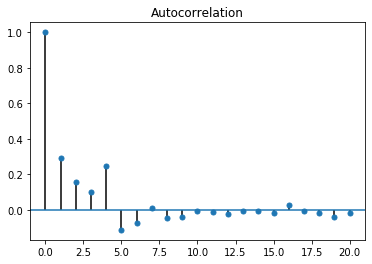

In [51]:
pmd.plot_acf(train['Weekly_Sales'])

Test for what the differencing coefficient (d) should be. Instructions from https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [52]:
ndiffs = pmd.arima.utils.ndiffs   

# Estimate the number of differences using an ADF (Augmented Dickey Fuller) test:
n_adf = ndiffs(train['Weekly_Sales'], test='adf')  # -> 0

In [53]:
n_adf

0

No differencing needed. Nice. 😀

`m=52` for the number of observations per seasonal cycle

Let's instantiate a model with a whole lot of arguments.

In [54]:
model = pmd.auto_arima(
    train['Weekly_Sales'], 
    start_p=1, 
    start_q=1,
    max_p=3, 
    max_q=3,
    d=0,                     # from ndiffs testing above
    seasonal=True, 
    m=52,
    error_action='ignore',   # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
)

Running this next cell might take some time. The `summary)` method is gridsearching, fitting lots of different models to the training data to see which hyperparameters work best.

In [55]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  100
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood               -1325.592
Date:                             Tue, 19 May 2020   AIC                           2663.185
Time:                                     18:57:51   BIC                           2678.816
Sample:                                          0   HQIC                          2669.511
                                             - 100                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.343e+05   6.81e-07   1.37e+12      0.000    9.34e+05    9.34e+05
ar.L1         -0.6017      0.285     -2.112      0.035      -1.160      -0.043
ar.L2          0.2897      0.132      2.197      0.028       0.031       0.548
ma.L1          0.8563      0.357      2.395      0.017       0.156       1.557
ar.S.L52       0.5377      0.085      6.342      0.000       0.372       0.704
sigma2      2.634e+10   2.85e-11   9.23e+20      0.000    2.63e+10    2.63e+10
===================================================================================
Ljung-Box (Q):                       23.17   Jarque-Bera (JB):               284.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                             1.75
Prob(H) (two-sided):                  0.26   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+37. Standard errors may be unstable.
"""

The Model displays the final parameters. Now we can the model object to predict the "future" values.

In [56]:
df_predictions['SARIMA_auto'] = model.predict(test.shape[0])

In [57]:
df_predictions['SARIMA_auto'].head()

Date
2012-01-06    1.525109e+06
2012-01-13    1.452850e+06
2012-01-20    1.440693e+06
2012-01-27    1.409214e+06
2012-02-03    1.586940e+06
Name: SARIMA_auto, dtype: float64

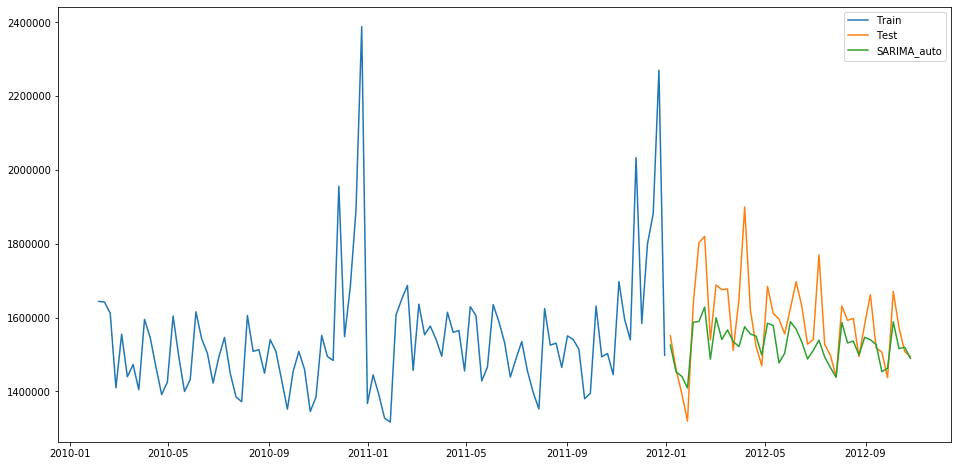

In [58]:
plt.figure(figsize=(16,8))
plt.plot( train['Weekly_Sales'], label='Train')
plt.plot(test['Weekly_Sales'], label='Test')
plt.plot(df_predictions['SARIMA_auto'], label='SARIMA_auto')
plt.legend(loc='best')
plt.show()

In [60]:
rms = mean_squared_error(
    test['Weekly_Sales'], 
    df_predictions['SARIMA_auto'],
    squared=False
)
print(f'{rms:,.0f}')

98,525


In [1]:
np.__version__

'1.18.1'

## That's all the time we have today! 😂